## import

In [1]:
import pandas as pd
import numpy as np
import json
import urllib

In [2]:
# 일반적인 모듈 
import numpy as np
import matplotlib.pyplot as plt 
import networkx as nx 
from tqdm import tqdm 

# 파이토치 관련 
import torch
import torch.nn.functional as F

# PyG 관련 
from torch_geometric.data import Data ## Data: 그래프자료형을 만드는 클래스

# STGCN 관련 
import torch_geometric_temporal
from torch_geometric_temporal.nn.recurrent import GConvGRU
from torch_geometric_temporal.signal import temporal_signal_split 

In [3]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [4]:
import pickle 
with open('stgcn.pickle', 'rb') as f: 
    model = pickle.load(f)

In [5]:
model

RecurrentGCN(
  (recurrent): GConvGRU(
    (conv_x_z): ChebConv(4, 32, K=2, normalization=sym)
    (conv_h_z): ChebConv(32, 32, K=2, normalization=sym)
    (conv_x_r): ChebConv(4, 32, K=2, normalization=sym)
    (conv_h_r): ChebConv(32, 32, K=2, normalization=sym)
    (conv_x_h): ChebConv(4, 32, K=2, normalization=sym)
    (conv_h_h): ChebConv(32, 32, K=2, normalization=sym)
  )
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

In [6]:
from mysolar import SolarDatasetLoader

In [7]:
loader = SolarDatasetLoader()
dataset = loader.get_dataset(lags=4)
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

In [8]:
np.array(dataset.features).shape

(18246, 44, 4)

## 모델평가

In [17]:
model.eval()
cost = 0
for time, snapshot in enumerate(train_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 0.1041


In [12]:
model.eval()
cost = 0
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 0.0934


In [9]:
yhat_train = torch.stack([model(snapshot.x,snapshot.edge_index, snapshot.edge_attr) for snapshot in train_dataset]).detach().numpy()
yhat_test = torch.stack([model(snapshot.x,snapshot.edge_index, snapshot.edge_attr) for snapshot in test_dataset]).detach().numpy()

In [10]:
url = 'https://raw.githubusercontent.com/pinkocto/noteda/main/posts/SOLAR/data/solar.json'
data_dict = json.loads(urllib.request.urlopen(url).read())
V = list(data_dict['node_ids'].keys())
f = np.array(data_dict["FX"])

## Visualization

In [11]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'

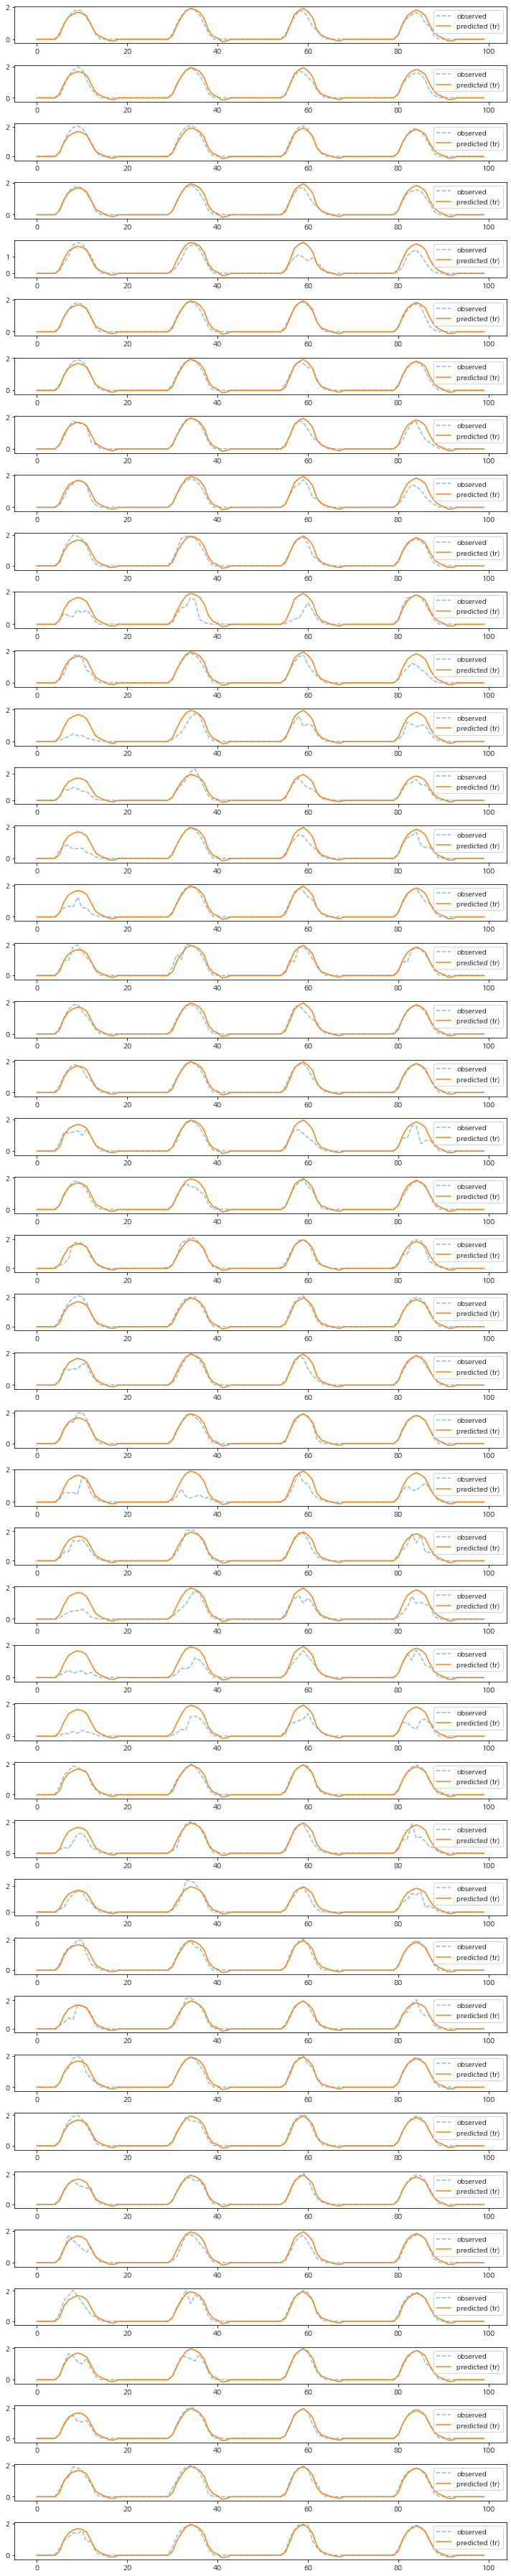

In [14]:
fig,ax = plt.subplots(44,1,figsize=(10,50))
for k in range(44):
    ax[k].plot(f[4:104,k],'--',alpha=0.5,label='observed')
    # ax[k].set_title('node: {}'.format(V[k]))
    ax[k].plot(yhat_train[:100,k],label='predicted (tr)')
    # ax[k].plot(range(yhat_train.shape[0],yhat_train.shape[0]+yhat_test.shape[0]),yhat_test[:,k],label='predicted (test)')
    ax[k].legend()
fig.tight_layout()